In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [5]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [6]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [7]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.012, train acc 0.997, test acc 0.925
2718.2 examples/sec on cuda:0


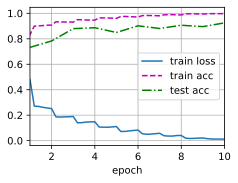

In [8]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

  0%|          | 0/500 [00:00<?, ?it/s]

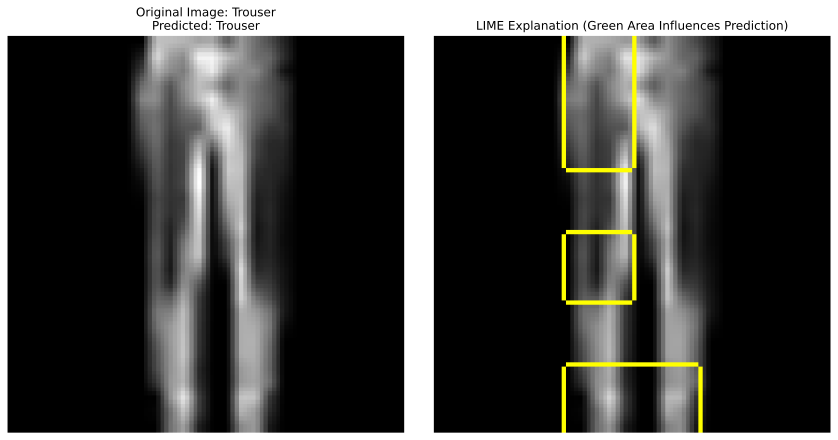

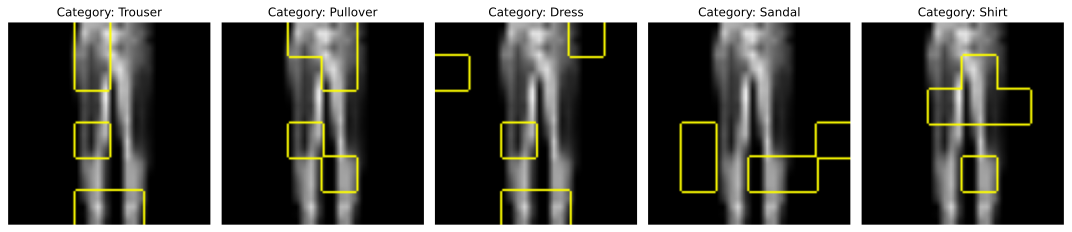

Feature importance for 'Trouser':
Feature 2: 2.1930
Feature 8: 1.7236
Feature 32: 1.4458
Feature 20: 1.3062
Feature 33: 1.1945
Feature 26: 1.0430
Feature 21: 1.0313
Feature 14: 0.9988
Feature 3: 0.9705
Feature 15: 0.5231


In [ ]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np

# 定义预测函数
# def predict_fn(images):
#     # 将图像转换为适合模型的格式
#     batch_size = images.shape[0]
#     # 对于灰度图像，确保形状正确
#     if len(images.shape) == 4 and images.shape[3] == 3:
#         # 如果是 RGB 格式，转换为灰度
#         images_gray = np.mean(images, axis=3)
#         images_reshaped = images_gray.reshape(batch_size, -1).astype('float32')
#     else:
#         # 已经是灰度图像
#         images_reshaped = images.reshape(batch_size, -1).astype('float32') 
    
#     # 使用您的模型进行预测
#     with torch.no_grad():
#         images_tensor = torch.tensor(images_reshaped)
#         probs = net(images_tensor).numpy()
    
#     return probs
def predict_fn(images):
    """预测函数，处理输入图像并返回预测结果"""
    # 确保输入是numpy数组
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    
    # 转换为灰度图像（如果模型期望单通道输入）
    if len(images.shape) == 4 and images.shape[3] == 3:  # batch of RGB images
        images = np.mean(images, axis=3, keepdims=True)  # 转换为灰度
    elif len(images.shape) == 3 and images.shape[2] == 3:  # single RGB image
        images = np.mean(images, axis=2, keepdims=True)  # 转换为灰度
    
    # 调整维度顺序为 [batch_size, channels, height, width]
    if len(images.shape) == 3:  # 单张图片
        images = np.expand_dims(images, axis=0)
    if len(images.shape) == 4 and images.shape[3] == 1:
        images = np.transpose(images, (0, 3, 1, 2))
    
    # 确保数据类型正确
    images = images.astype(np.float32)
    # 转换为torch tensor并确保类型正确
    with torch.no_grad():
        images_tensor = torch.FloatTensor(images)
        # 如果需要，移动到GPU
        if torch.cuda.is_available():
            images_tensor = images_tensor.cuda()
            net.cuda()
        
        # 进行预测
        outputs = net(images_tensor)
        # 如果在GPU上，移回CPU
        if torch.cuda.is_available():
            outputs = outputs.cpu()
        probs = outputs.numpy()
    
    return probs


# 创建解释器
explainer = lime_image.LimeImageExplainer()

# 定义分割算法
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# 从测试集获取一个样本
for X, y in test_iter:
    break

# 选择一个样本
idx = 65 # 可以尝试不同的索引
image = X[idx].numpy().transpose(1, 2, 0)  # 转换为 (H, W, C) 格式
image = image.squeeze()  # 移除通道维度，因为 Fashion-MNIST 是灰度图像
label = y[idx].item()

# 获取标签名称
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
true_label = label_names[label]

# 生成解释
# explanation = explainer.explain_instance(
#     image, 
#     predict_fn, 
#     top_labels=5, 
#     hide_color=0, 
#     num_samples=5000,
#     segmentation_fn=segmenter
# )
def grid_segments(image, grid_size=16):
    """创建简单的网格分割"""
    segments = np.zeros(image.shape[:2], dtype=np.int32)
    h, w = image.shape[:2]
    h_step, w_step = h // grid_size, w // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            segments[i*h_step:(i+1)*h_step, j*w_step:(j+1)*w_step] = i * grid_size + j
    return segments

# 使用 4x4 网格，共 16 个超像素
explanation = explainer.explain_instance(
    image, 
    predict_fn, 
    top_labels=5, 
    hide_color=0, 
    num_samples=500,
    batch_size=50,
    segmentation_fn=lambda x: grid_segments(x, grid_size=6)
)
# 获取预测标签
pred = predict_fn(np.expand_dims(image, axis=0))[0]
pred_idx = np.argmax(pred)
pred_label = label_names[pred_idx]

# 显示原始图像和解释
plt.figure(figsize=(12, 6))

# 原始图像
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Original Image: {true_label}\nPredicted: {pred_label}')
plt.axis('off')

# LIME 解释
temp, mask = explanation.get_image_and_mask(
    pred_idx, 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask), cmap='gray')
plt.title('LIME Explanation (Green Area Influences Prediction)')
plt.axis('off')

plt.tight_layout()
plt.show()

# 显示不同标签的解释
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, label_id in enumerate(explanation.top_labels[:5]):
    temp, mask = explanation.get_image_and_mask(
        label_id, 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    axes[i].imshow(mark_boundaries(temp, mask), cmap='gray')
    axes[i].set_title(f'Category: {label_names[label_id]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 打印特征重要性
print(f"Feature importance for '{pred_label}':")
for feature, importance in explanation.local_exp[pred_idx][:10]:
    print(f"Feature {feature}: {importance:.4f}")